#DQN Implementation on CartPole-v0
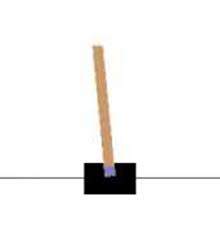

Let's first install all relevant libraries through pip.

In [1]:
!pip install gym tensorflow numpy matplotlib

Import all relevant libraries

In [1]:
import sys
import gym
import numpy as np
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from pyvirtualdisplay import Display
#from gym.wrappers.monitoring import video_recorder



/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_47149/1902816938.py:9: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, 'bool8'):
/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/google/protobuf/runti

Write up a DQN class that builds the model, build the replay buffer, implements epsilon-greedy exploration and updates the Q network.

In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.9  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01 # minimum epsilon
        self.epsilon_decay = 0.995 #rate of epsilon decay
        self.learning_rate = 0.001
        self.model = self._build_model()#build the model

    def _build_model(self):
        #this function builds the MLP model with relu activations in 2 the hidden layers, and linear activation in the output layer
        model = models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=self.learning_rate))#specify the type of loss and the learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        #This function pushes instances of experience into the replay buffer
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, action_list):
        #epsilon-greedy exploration to select actions
        if np.random.rand() <= self.epsilon:
            return np.random.choice(action_list)
        act_values = self.model.predict(state,verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = np.random.choice(len(self.memory), batch_size, replace=False)#select a minibatch of size batch_size
        states = np.array([self.memory[i][0].flatten() for i in minibatch])
        actions = np.array([self.memory[i][1] for i in minibatch])
        rewards = np.array([self.memory[i][2] for i in minibatch])
        next_states = np.array([self.memory[i][3].flatten() for i in minibatch])
        dones = np.array([self.memory[i][4] for i in minibatch])

        targets = rewards + self.gamma * np.amax(self.model.predict_on_batch(next_states), axis=1) * (1 - dones)#form the learning targets
        target_f = self.model.predict_on_batch(states)#current estimate of Q values
        target_f[np.arange(batch_size), actions] = targets#update only the Q values corresponding to the action taken. Leave the others unchanged.

        self.model.fit(states, target_f, epochs=1, verbose=0)#train the model

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)



Let's put it all together in the main loop.

In [ ]:
env = gym.make("highway-v0", render_mode="rgb_array")
# Handle observation space - flatten if needed
obs_space = env.observation_space
if hasattr(obs_space, 'shape'):
    state_size = np.prod(obs_space.shape)
else:
    state_size = obs_space.n
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)#initialise the agent
batch_size = 32 #set batch size
EPISODES = 30 #Set total number of episodes you want the training to last
total_rewards_log=[]

for e in range(EPISODES):
    state, info = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward=0
    done = False
    while done is False:#upto 200 steps in the episode
        env.unwrapped.render()
        action = agent.act(state = state, action_list=[0,2])#epsilon-greedy action
        next_state, reward, done, truncated, info = env.step(action)#take the action, get reward and next state
        done = done or truncated
        reward = reward if not done else -10
        total_reward+=reward# keep track of total rewards
        next_state = np.reshape(next_state, [1, state_size])#reshape states to vectorised form
        agent.remember(state, action, reward, next_state, done)#store in replay buffer
        state = next_state
        if len(agent.memory) > batch_size:#if there are enough samples to form a batch then call experience replay
            agent.replay(batch_size)#update the DQN weights through replay
    total_rewards_log.append(total_reward)#log the total rewards in the episode


/opt/anaconda3/envs/rl_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'NoneType' object has no attribute 'get_image'

: 

Now plot the results

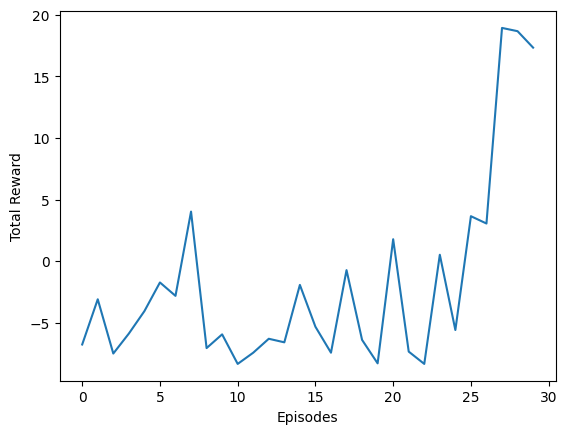

: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(total_rewards_log)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()


We can see that DQN is learning . The longer you run it, the better and more stable it will get. Compare this performance with that of week 7's workshop. What do you notice? Why?